# Conspicuity!!!

In [1]:
# Installations
!pip install qiskit
!pip install pennylane
!pip install pennylane-lightning[kokkos]
# !pip install pennylane-lightning
# !pip install pennylane-lightning[gpu]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 36.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 38.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 81.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 3.5 MB/s eta 0:00:0000:0100:01


## Imports and Configs

In [2]:
from pathlib import Path
import json
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import random

import torch
import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pennylane.numpy as np
import pennylane as qml
from pennylane.templates import RandomLayers
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Path defs and Data fetching

In [3]:
# Data Configs
DATAPATH = Path("/kaggle/input/tig-aluminium-5083/al5083")
OUTPATH = Path("/kaggle/working/")
BATCH_SIZE = 1

In [4]:
# Defining PyTorch compatible dataset for efficient dataloading
class TIGDataset(Dataset):
    def __init__(self, datapath, preprocess: bool = True, datatype: str = "train", penny=True):
        self.preprocess = preprocess
        self.datapath = datapath
        self.datatype = datatype
        self.penny = penny
        
        with open (datapath/self.datatype/f"{self.datatype}.json", "r") as f:
            self.metadata = json.load(f)
        
        self.data = [(k, v) for k, v in self.metadata.items()]
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(self.datapath/self.datatype/image_path)
        if self.preprocess:  # Convert to grayscale, normalize, then resize to lower dimension
            image = normalize(image.convert('L').resize((112, 112)))
        if self.penny:
            image = np.array(image).squeeze()
        else:
            image = torch.tensor(image, dtype=torch.float32)
        return image, label
    

In [5]:
# Defining train and test dataloaders

# Pennylane format
trainset_penny = TIGDataset(datapath=DATAPATH, preprocess=True, datatype="train", penny=True)
testset_penny = TIGDataset(datapath=DATAPATH, preprocess=True, datatype="test", penny=True)

trainloader_penny = DataLoader(trainset_penny, batch_size=BATCH_SIZE, shuffle=True)
testloader_penny = DataLoader(testset_penny, batch_size=BATCH_SIZE, shuffle=False)

# PyTorch format
trainset_torch = TIGDataset(datapath=DATAPATH, preprocess=True, datatype="train", penny=False)
testset_torch = TIGDataset(datapath=DATAPATH, preprocess=True, datatype="test", penny=False)

trainloader_torch = DataLoader(trainset_torch, batch_size=BATCH_SIZE, shuffle=True)
testloader_torch = DataLoader(testset_torch, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
def ppmetrics(y_true, y_pred, pname="classical"):
    # function to print and plot metrics
    retval = (accuracy_score(y_true, y_pred), classification_report(y_true, y_pred), confusion_matrix(y_true, y_pred))
    
    print("".join(["="]*20) + f" Metrics for {pname} " + "".join(["="]*20))
    print("\n\n")
    
    print("".join(["*"]*10) + f" Accuracy Score " + "".join(["*"]*10))
    print("\n")
    print(f"Accuracy: {retval[0]}")
    print("\n")
    print("".join(["*"]*15) + "".join(["*"]*15))
    
    print("\n\n")
    
    print("".join(["*"]*10) + f" Classification report " + "".join(["*"]*10))
    print("\n")
    print(retval[1])
    print("\n")
    print("".join(["*"]*15) + "".join(["*"]*15))
    
    print("\n\n")
    
    print("".join(["*"]*10) + f" Confusion Matrix " + "".join(["*"]*10))
    print("\n")
    cmp = ConfusionMatrixDisplay(retval[2])
    cmp.plot()
    plt.show()
    print("\n")
    print("".join(["*"]*15) + "".join(["*"]*15))
    return retval

## Classical models

In [7]:
# Defining CNN Encoder model with random weights
class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # Conv Layer 1 - 112x112x1
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=2, stride=2),
#             nn.BatchNorm1d(4),
            nn.InstanceNorm1d(4),
            nn.ReLU(),
            
            # Conv Layer 2 - 56x56x4
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=2, stride=2),
#             nn.BatchNorm1d(16),
            nn.InstanceNorm1d(16),
            nn.ReLU(),
            
            # Conv Layer 3 - 28x28x16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=2),
#             nn.BatchNorm1d(32),
            nn.InstanceNorm1d(32),
            nn.ReLU(),
            
            # Conv Layer 4 - 14x14x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2),
#             nn.BatchNorm1d(64),
            nn.InstanceNorm1d(64),
            nn.ReLU(),
        )
        
        self.linear = nn.Sequential(
            # Linear Layer 1 - 7x7x64
            nn.Linear(in_features=7*7*64, out_features=700),
            nn.ReLU(),
            
            # Linear Layer 2 - 700
            nn.Linear(in_features=700, out_features=100),
            nn.ReLU(),
            
            # Linear Layer 3 - 100
            nn.Linear(in_features=100, out_features=10),
            nn.ReLU(),
        )
    
        self.linear.apply(self.init_weights)
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1)
        out = self.linear(x)
        return out

In [8]:
# Function to encode all data into features for KNN
def encode_features(model, dataloader, force_cpu=False):
    encoded_data = []
    if force_cpu:
        device = torch.device("cpu")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    for i, (X, y) in tqdm(enumerate(dataloader)):
        with torch.no_grad():
            X = X.to(device)
            X_encoded = list(model(X).cpu().detach().numpy())
            cols = [f"X{i}" for i in range(len(X_encoded))] + ["y"]
            datarow = dict(zip(cols, X_encoded + list(y.numpy())))
            encoded_data.append(datarow)
    return pd.DataFrame(encoded_data)

In [23]:
# # Encoding training images and testing images into features for KNN without training
# train_df = encode_features(ConvEncoder(), trainloader_torch, force_cpu=False)
# test_df = encode_features(ConvEncoder(), testloader_torch, force_cpu=False)

# train_df.to_csv(OUTPATH / "train_classical.csv", index=False)
# test_df.to_csv(OUTPATH / "test_classical.csv", index=False)

In [ ]:
# Loading dataframes
train_df = pd.read_csv(OUTPATH / "train_classical.csv")
test_df = pd.read_csv(OUTPATH / "test_classical.csv")

drop_cols_train = [col for col in train_df.columns if col.startswith("Unnamed")]
drop_cols_test = [col for col in test_df.columns if col.startswith("Unnamed")]

train_df.drop(drop_cols_train, axis=1, inplace=True)
test_df.drop(drop_cols_test, axis=1, inplace=True)

# train_df = train_df.apply(lambda x: eval(x).item())
# test_df = test_df.apply(lambda x: eval(x).item())

In [25]:
# Training KNN on classical data
X, y = train_df.drop("y", axis=1).to_numpy(), train_df["y"].to_numpy()

knn_classical = KNeighborsClassifier(n_neighbors=7)
knn_classical.fit(X, y)

KNeighborsClassifier(n_neighbors=7)

==================== Metrics for classical ====================



********** Accuracy Score **********


Accuracy: 0.24468731026108076


******************************



********** Classification report **********


              precision    recall  f1-score   support

           0       0.37      0.36      0.37      2189
           1       0.00      0.00      0.00       351
           2       0.27      0.32      0.29      2078
           3       0.00      0.00      0.00      1007
           4       0.11      0.20      0.15       729
           5       0.00      0.01      0.00       234

    accuracy                           0.24      6588
   macro avg       0.13      0.15      0.14      6588
weighted avg       0.22      0.24      0.23      6588



******************************



********** Confusion Matrix **********




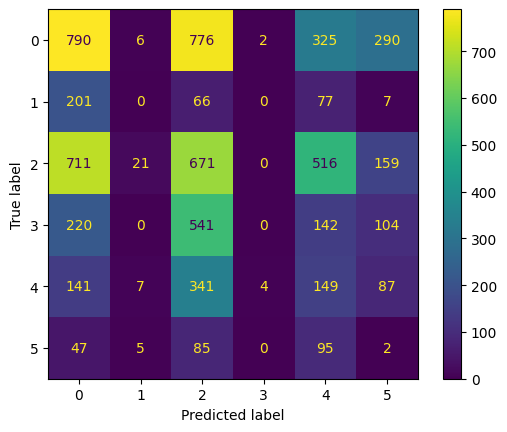



******************************


In [26]:
# Testing KNN with classical encoding of features
X_test, y_test = test_df.drop("y", axis=1).to_numpy(), test_df["y"].to_numpy()
y_pred = knn_classical.predict(X_test)

acc, cr, cm = ppmetrics(y_test, y_pred, "classical")

## Quantum models
- We use Quanvolution to encode the data into features here

In [13]:
dev = qml.device("lightning.kokkos", wires=4)
n_layers = 1  # Number of random layers
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))
image_size = (112, 112)

@qml.qnode(dev)
def circuit(phi):
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))
    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

def quanv(arr):
    out = np.zeros((int(arr.shape[0]/2), int(arr.shape[1]/2), 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, arr.shape[0], 2):
        for k in range(0, arr.shape[1], 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    arr[j, k,],
                    arr[j, k + 1],
                    arr[j + 1, k],
                    arr[j + 1, k + 1]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [14]:
# class QConvLayer():
#     def __init__(self, in_channels, out_channels, image_size):
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.image_size = image_size
#         self.n_layers = 1    # Number of random layers
#         self.rand_params = np.random.uniform(high=2 * np.pi, size=(self.n_layers, out_channels))
        
#     @qml.qnode(dev)
#     def circuit(self, phi):
#         for j in range(self.out_channels):
#             qml.RY(np.pi * phi[j], wires=j)

#         # Random quantum circuit
#         RandomLayers(self.rand_params, wires=list(range(self.out_channels)))
#         # Measurement producing 4 classical output values
#         return [qml.expval(qml.PauliZ(j)) for j in range(self.out_channels)]
    
#     def quanv(self, arr):
#         out = np.zeros((int(arr.shape[0]/2), int(arr.shape[1]/2), self.out_channels))

#         # Loop over the coordinates of the top-left pixel of 2X2 squares
#         for j in range(0, arr.shape[0], 2):
#             for k in range(0, arr.shape[1], 2):
#                 # Process a squared 2x2 region of the image with a quantum circuit
#                 q_results = self.circuit(
#                     [
#                         arr[j, k,],
#                         arr[j, k + 1],
#                         arr[j + 1, k],
#                         arr[j + 1, k + 1]
#                     ]
#                 )
#                 # Assign expectation values to different channels of the output pixel (j/2, k/2)
#                 for c in range(self.out_channels):
#                     out[j // 2, k // 2, c] = q_results[c]
#         return out

    
# Defining Quantum CNN Encoder model with random weights - One Conv Layer + remaining classical layers

class QConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
#         self.qconv = QConvLayer(1, 4, (112, 112))

        self.conv = nn.Sequential(
            # Conv Layer 1 - 56x56x4
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=2, stride=2),
#             nn.BatchNorm1d(16),
            nn.InstanceNorm1d(16),
            nn.ReLU(),
            
            # Conv Layer 2 - 28x28x16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=2),
#             nn.BatchNorm1d(32),
            nn.InstanceNorm1d(32),
            nn.ReLU(),
            
            # Conv Layer 3 - 14x14x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2),
#             nn.BatchNorm1d(64),
            nn.InstanceNorm1d(64),
            nn.ReLU(),
        )
        
        self.linear = nn.Sequential(
            # Linear Layer 1 - 7x7x64
            nn.Linear(in_features=7*7*64, out_features=700),
            nn.ReLU(),
            
            # Linear Layer 2 - 700
            nn.Linear(in_features=700, out_features=100),
            nn.ReLU(),
            
            # Linear Layer 3 - 100
            nn.Linear(in_features=100, out_features=10),
            nn.ReLU(),
        )
    
        self.linear.apply(self.init_weights)
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def forward(self, x):
        x = quanv(x.squeeze())
        x = torch.tensor(x, dtype=torch.float32).view(4, 56, 56)
        x = self.conv(x)
        x = x.view(-1)
        out = self.linear(x)
        return out

In [ ]:
# Encoding training images and testing images into features for KNN without training
train_df_Q = encode_features(QConvEncoder(), trainloader_penny, force_cpu=True)
test_df_Q = encode_features(QConvEncoder(), testloader_penny, force_cpu=True)

train_df_Q.to_csv(OUTPATH / "train_quantum.csv", index=False)
test_df_Q.to_csv(OUTPATH / "test_quantum.csv", index=False)

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
/opt/conda/lib/python3.10/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You

In [ ]:
# Loading dataframes
train_df_Q = pd.read_csv(OUTPATH / "train_quantum.csv")
test_df_Q = pd.read_csv(OUTPATH / "test_quantum.csv")

drop_cols_train = [col for col in train_df_Q.columns if col.startswith("Unnamed")]
drop_cols_test = [col for col in test_df_Q.columns if col.startswith("Unnamed")]

train_df_Q.drop(drop_cols_train, axis=1, inplace=True)
test_df_Q.drop(drop_cols_test, axis=1, inplace=True)

# train_df = train_df.apply(lambda x: eval(x).item())
# test_df = test_df.apply(lambda x: eval(x).item())

In [ ]:
# Training KNN on quantum data
Xq, yq = train_df_Q.drop("y", axis=1).to_numpy(), train_df_Q["y"].to_numpy()

knn_quantum = KNeighborsClassifier(n_neighbors=7)
knn_quantum.fit(Xq, yq)

In [ ]:
# Testing KNN with quantum encoding of features
X_test_Q, y_test_Q = test_df_Q.drop("y", axis=1).to_numpy(), test_df_Q["y"].to_numpy()
y_pred_Q = knn_quantum.predict(X_test_Q)

accQ, crQ, cmQ = ppmetrics(y_test_Q, y_pred_Q, "quantum")